In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from matplotlib.ticker import MultipleLocator

np.set_printoptions(precision=5)

In [23]:
RISKY_ASSET = "0388.HK"
START_DATE = '2023-01-01'
END_DATE = '2023-06-01'

In [24]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 progress=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 99 rows of data.


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,330.600006,345.000000,329.000000,343.000000,339.248749,4683105
2023-01-04,344.799988,354.000000,343.200012,354.000000,350.128448,5561041
2023-01-05,360.000000,365.000000,359.200012,361.799988,357.843140,7675714
2023-01-06,360.200012,366.000000,358.200012,362.399994,358.436584,6264530
2023-01-09,370.000000,382.399994,367.000000,377.399994,373.272522,8422963


In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [25]:
df = df.drop('Close', axis=1)
df.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2023-01-03,330.600006,345.000000,329.000000,339.248749,4683105
2023-01-04,344.799988,354.000000,343.200012,350.128448,5561041
2023-01-05,360.000000,365.000000,359.200012,357.843140,7675714
2023-01-06,360.200012,366.000000,358.200012,358.436584,6264530
2023-01-09,370.000000,382.399994,367.000000,373.272522,8422963


In [26]:
# Select all columns except the second last column: 'Adj Close'
# X = df.loc[:, ~df.columns.isin(['Adj Close'])]
X = df.iloc[:, :-2].join(df.iloc[:, -1:])
y = df.iloc[:, -2]

In [9]:
X.head()

,Open,High,Low,Volume
Date,,,,
2023-01-03,330.600006,345.000000,329.000000,4683105
2023-01-04,344.799988,354.000000,343.200012,5561041
2023-01-05,360.000000,365.000000,359.200012,7675714
2023-01-06,360.200012,366.000000,358.200012,6264530
2023-01-09,370.000000,382.399994,367.000000,8422963


In [10]:
y.head()

Date
2023-01-03    339.248749
2023-01-04    350.128448
2023-01-05    357.843140
2023-01-06    358.436584
2023-01-09    373.272522
Name: Adj Close, dtype: float64

In [27]:
#not using the random split since the time series data
#using the last month data as test
TEST_LENGTH = 20
X_train = X.iloc[:-TEST_LENGTH]
X_test = X.iloc[-TEST_LENGTH:]
y_train = y.iloc[:-TEST_LENGTH]
y_test = y.iloc[-TEST_LENGTH:]

In [12]:
# # train:test = 8:2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [13]:
grid = {'alpha': 10**np.linspace(start=-3, stop=3, num=50)}
print(grid["alpha"]) # A grid of lambdas

[1.00000e-03 1.32571e-03 1.75751e-03 2.32995e-03 3.08884e-03 4.09492e-03
 5.42868e-03 7.19686e-03 9.54095e-03 1.26486e-02 1.67683e-02 2.22300e-02
 2.94705e-02 3.90694e-02 5.17947e-02 6.86649e-02 9.10298e-02 1.20679e-01
 1.59986e-01 2.12095e-01 2.81177e-01 3.72759e-01 4.94171e-01 6.55129e-01
 8.68511e-01 1.15140e+00 1.52642e+00 2.02359e+00 2.68270e+00 3.55648e+00
 4.71487e+00 6.25055e+00 8.28643e+00 1.09854e+01 1.45635e+01 1.93070e+01
 2.55955e+01 3.39322e+01 4.49843e+01 5.96362e+01 7.90604e+01 1.04811e+02
 1.38950e+02 1.84207e+02 2.44205e+02 3.23746e+02 4.29193e+02 5.68987e+02
 7.54312e+02 1.00000e+03]


In [28]:
# 5-Fold Cross Validation for lambda
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=7) # cv: cross validation
MSE = lambda y_true, y_hat: np.mean((y_true - y_hat)**2) # Function for MSE
MAE = lambda y_true, y_hat: np.mean(abs(y_true - y_hat)) # Function for MAE

In [29]:
# display(X_train)

In [30]:
# Standardizing training set and test set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# display(X_train)

In [32]:
# LinearRegression() class in sklearn does not provide a statistical summary
LINEAR = LinearRegression().fit(X_train, y_train)

# Print the model coefficients and intercept
print('Coefficients:', LINEAR.coef_)
print('Intercept:', LINEAR.intercept_)

Coefficients: [-7.31347  9.18537 12.2679  -0.295  ]
Intercept: 339.4735598020916


In [33]:
# Use the OLS() in statsmodel instead and manually include the intercept term
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     519.4
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           2.59e-53
Time:                        16:12:25   Log-Likelihood:                -190.00
No. Observations:                  79   AIC:                             390.0
Df Residuals:                      74   BIC:                             401.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        339.4736      0.312   1089.303      0.0

In [34]:
# for table in model.summary().tables:
#     print(table.as_latex_tabular())
# print(model.summary().as_latex())

In [35]:
LASSO_cv = GridSearchCV(Lasso(), grid, scoring="neg_mean_squared_error", cv=cv)
LASSO = LASSO_cv.fit(X_train, y_train)
print(LASSO.best_params_)
print(LASSO_cv.best_estimator_.coef_)

LASSO_pred = LASSO.predict(X_test)
LASSO_MSE = MSE(y_test, LASSO_pred)
LASSO_MAE = MAE(y_test, LASSO_pred)

{'alpha': 0.03906939937054617}
[-5.56723  8.39067 11.30111 -0.27311]


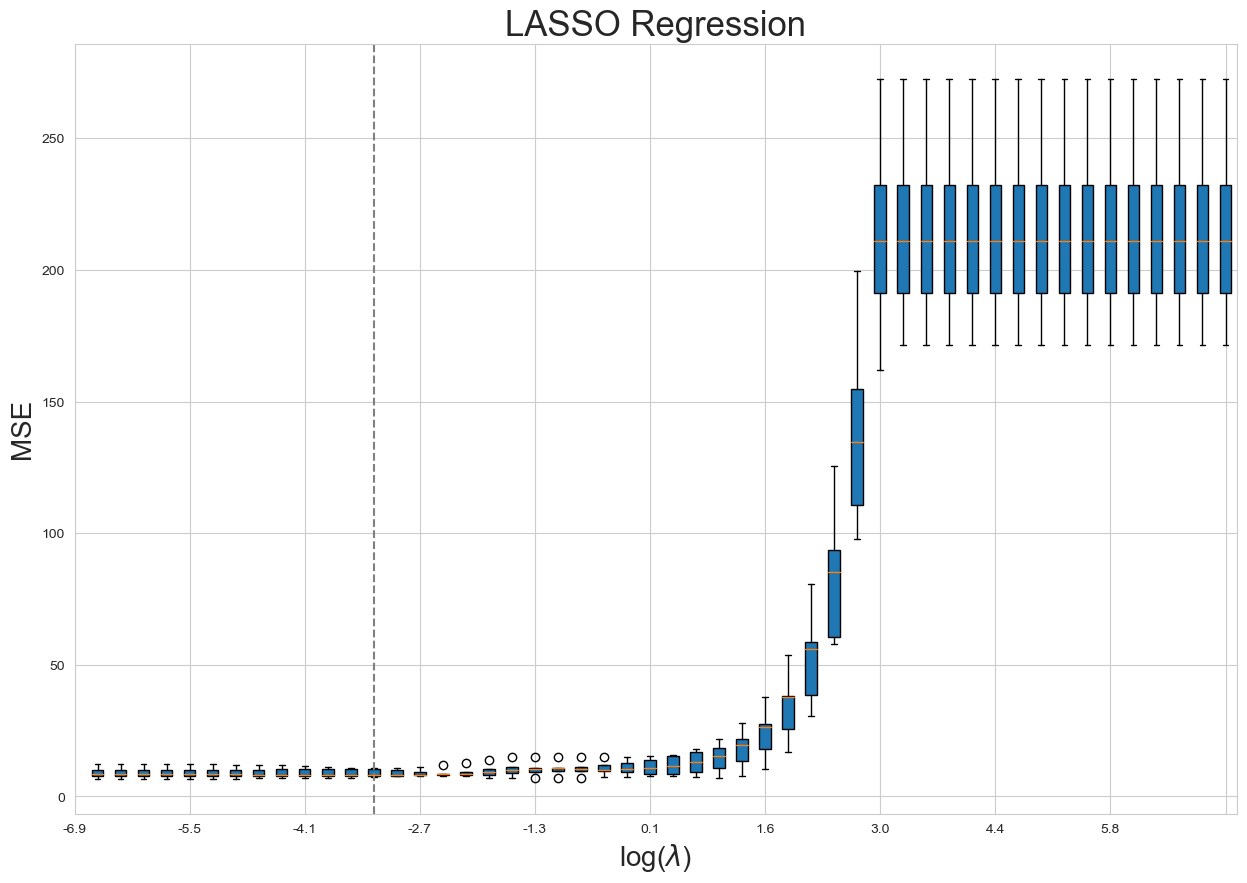

In [36]:
# GridSearchCV() in Python not have a plotting function for the results obtained.
LASSO_scores = np.array([LASSO.cv_results_[f"split{k}_test_score"] for k in range(5)])

fig, ax = plt.subplots(figsize=(15, 10))
plt.boxplot(-LASSO_scores, patch_artist=True)
plt.xticks(ticks=np.arange(len(grid["alpha"])), labels=np.round(np.log(grid["alpha"]), 1))
plt.title("LASSO Regression", fontsize=25)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.xlabel('log($\lambda$)', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.axvline(x=np.where(grid["alpha"] == LASSO.best_params_["alpha"])[0],
            linestyle="--", color="gray")

In [37]:
RIDGE_cv = GridSearchCV(Ridge(), grid, scoring="neg_mean_squared_error", cv=cv)
RIDGE = RIDGE_cv.fit(X_train, y_train)
print(RIDGE.best_params_)
print(RIDGE_cv.best_estimator_.coef_)

RIDGE_pred = RIDGE.predict(X_test)
RIDGE_MSE = MSE(y_test, LASSO_pred)
RIDGE_MAE = MAE(y_test, LASSO_pred)

{'alpha': 0.3727593720314938}
[-5.60855  8.86948 10.87837 -0.36319]


[-1.31383  1.2639   0.02987  0.02007]


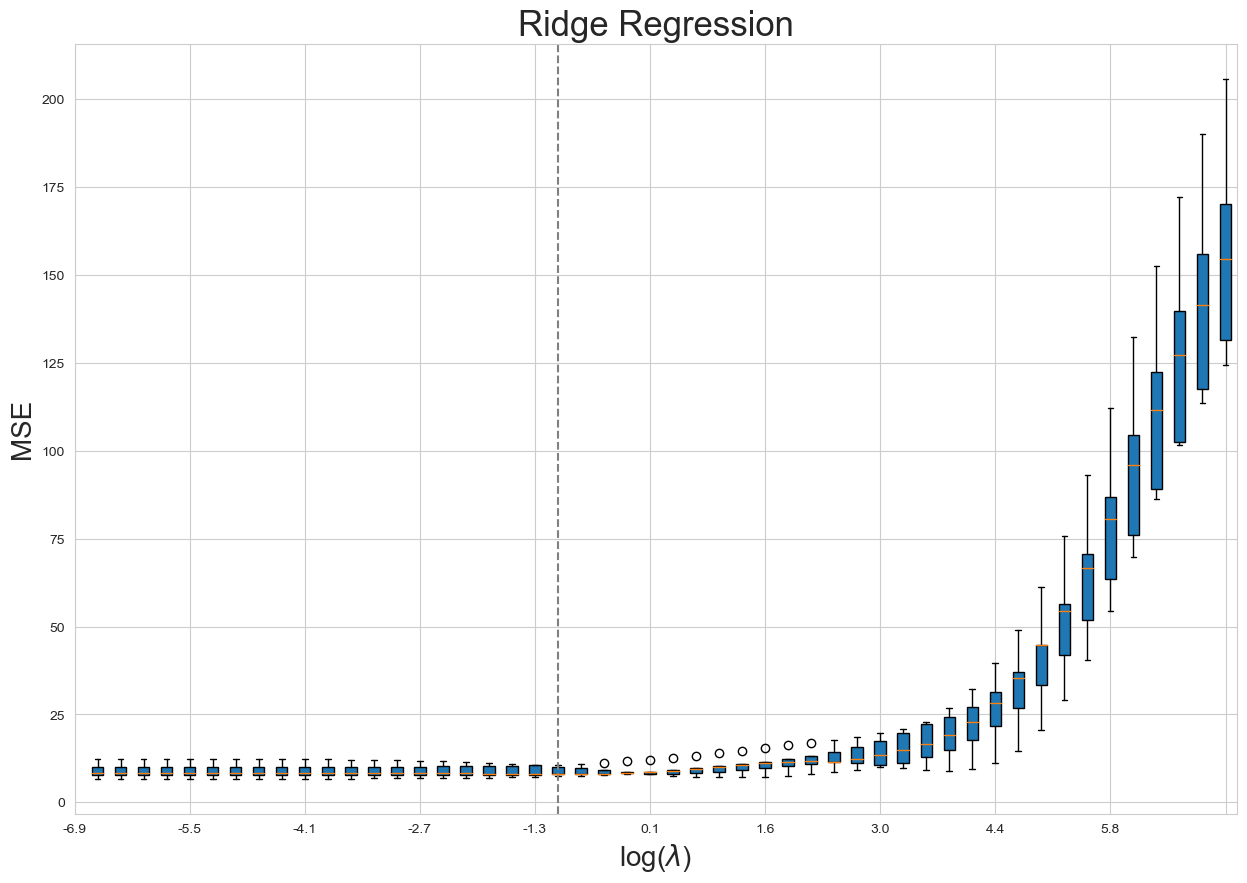

In [38]:
RIDGE_scores = np.array([RIDGE.cv_results_[f"split{k}_test_score"] for k in range(5)])

fig, ax = plt.subplots(figsize=(15, 10))
plt.boxplot(-RIDGE_scores, patch_artist=True)
plt.xticks(ticks=np.arange(len(grid["alpha"])), labels=np.round(np.log(grid["alpha"]), 1))
plt.title("Ridge Regression", fontsize=25)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.xlabel("log($\lambda$)", fontsize=20)
plt.ylabel("MSE", fontsize=20)
plt.axvline(x=np.where(grid["alpha"] == RIDGE.best_params_["alpha"])[0],
            linestyle="--", color="gray")

val, vec = np.linalg.eig(X_train.T @ X_train / len(y_train) - 1)
print(val)